<a href="https://colab.research.google.com/github/javad-sheikh/Generate-Cats-Dogs/blob/main/GAN_ANN_HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt, zipfile
import os
import glob
import math
import random
import time
import datetime
import shutil
import pickle
import imageio
from tqdm import tqdm, tqdm_notebook

from dataclasses import dataclass
from pathlib import Path
import warnings
from scipy import linalg

import xml.etree.ElementTree as ET 

import cv2
from PIL import Image

import tensorflow as tf
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape,\
Conv2DTranspose, Conv2D, Flatten, Dropout, Embedding, ReLU
from tensorflow.keras.optimizers import Adam
# from tf.contrib.eager.python import tfe

#from IPython import display

# libraries for SpectralNorm
from tensorflow.keras import backend as K
from keras.engine import *
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from keras.utils.generic_utils import deserialize_keras_object
from keras.utils.generic_utils import has_arg
from keras.utils import conv_utils

In [3]:
# !rm -rf Cat_Dog_data.zip
# !ls
%cd drive/My\ Drive/ANN/HW7

/content/drive/My Drive/ANN/HW7


In [4]:
import tensorflow_datasets as tfds

In [5]:
data,info = tfds.load("cats_vs_dogs",split="train",as_supervised=True,with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete4D6HKG/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [6]:
count = 0
train_images = []
for ex in tfds.as_numpy(data):
    count +=1
    if(count%1000==0):
        print(count)
    if(count==20001):
        break
    res = cv2.resize(ex[0], dsize=(96, 96), interpolation=cv2.INTER_CUBIC)
    # gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
    train_images.append(res)
train_images = np.array(train_images)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


In [7]:
image_width = 96
image_height = 96
image_channels = 3
image_sample_size = 10000
image_output_dir = 'output_images/'
OUT_DIR = Path('output_images/')

In [8]:
train_images.shape

(20000, 96, 96, 3)

In [9]:
def plot_features(features, image_width=image_width, image_height=image_height, 
                image_channels=image_channels,
                examples=25): 
  
    if not math.sqrt(examples).is_integer():
        print('Please select a valid number of examples.')
        return
    
    imgs = []
    for i in range(examples):
        rnd_idx = np.random.randint(0, len(features))
        imgs.append(features[rnd_idx, :, :, :])
    
    
    fig, axes = plt.subplots(round(math.sqrt(examples)), round(math.sqrt(examples)),figsize=(15,15),
    subplot_kw = {'xticks':[], 'yticks':[]},
    gridspec_kw = dict(hspace=0.3, wspace=0.01))
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(imgs[i])

Plotting cropped images by their specified coordinates..


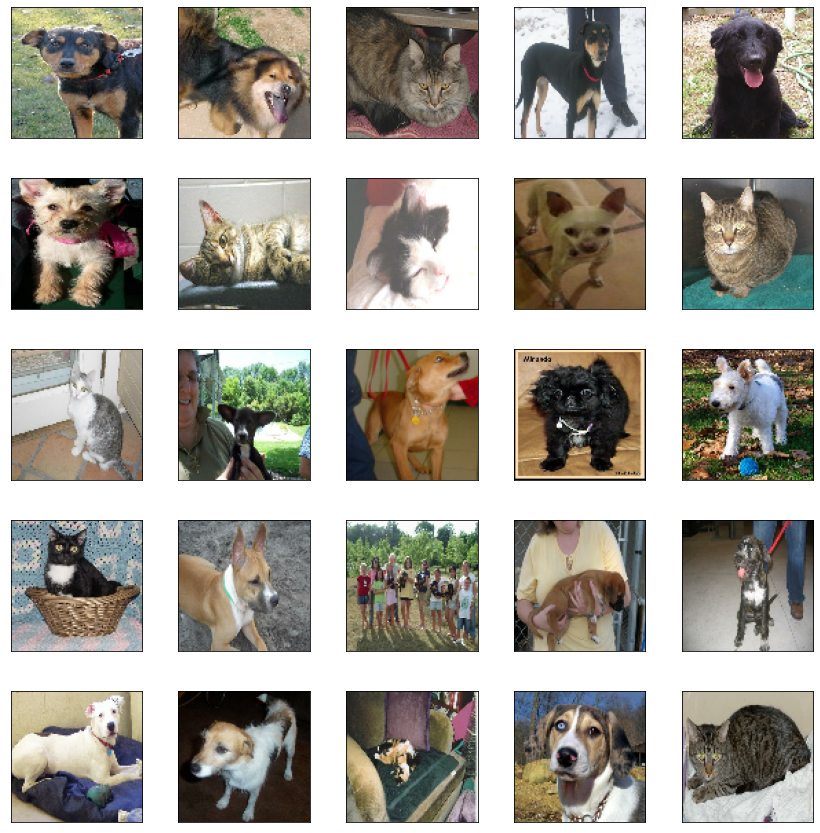

In [10]:
print('Plotting cropped images by their specified coordinates..')
plot_features(train_images / 255., examples=25)

In [11]:
train_images = (train_images) / 255  # normalize the pixel range to [-1, 1] ((image - 127.5) / 127.5) or [0, 1] (image / 255.) alternatively

Plotting cropped images by their specified coordinates..


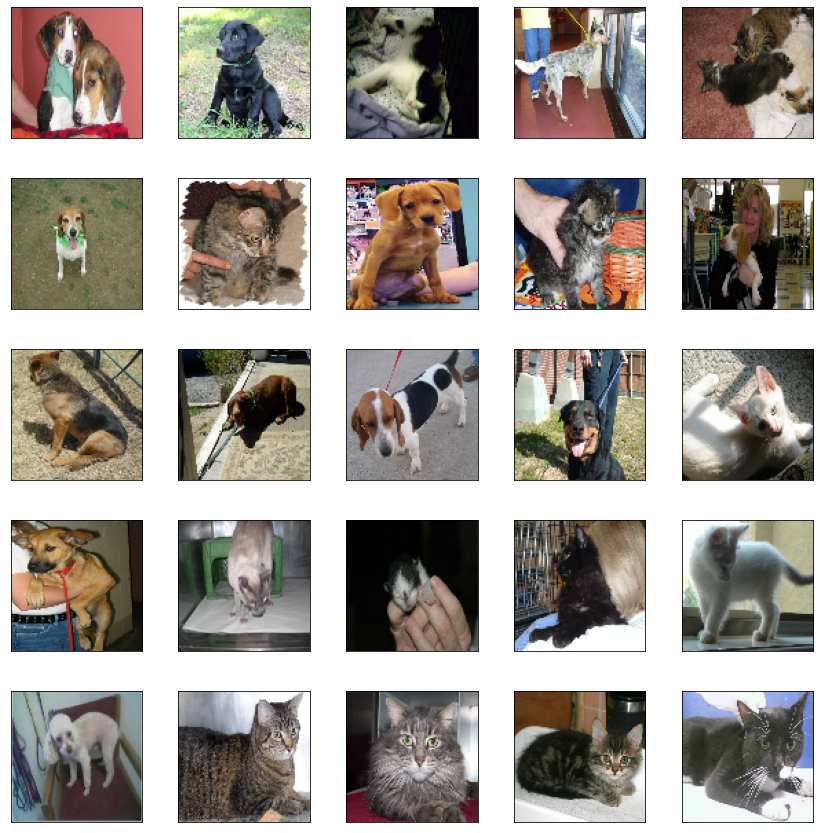

In [12]:
print('Plotting cropped images by their specified coordinates..')
plot_features(train_images,examples=25)

In [13]:
print(np.max(train_images[3,:,:,:]), np.min(train_images[3,:,:,:]))

1.0 0.0


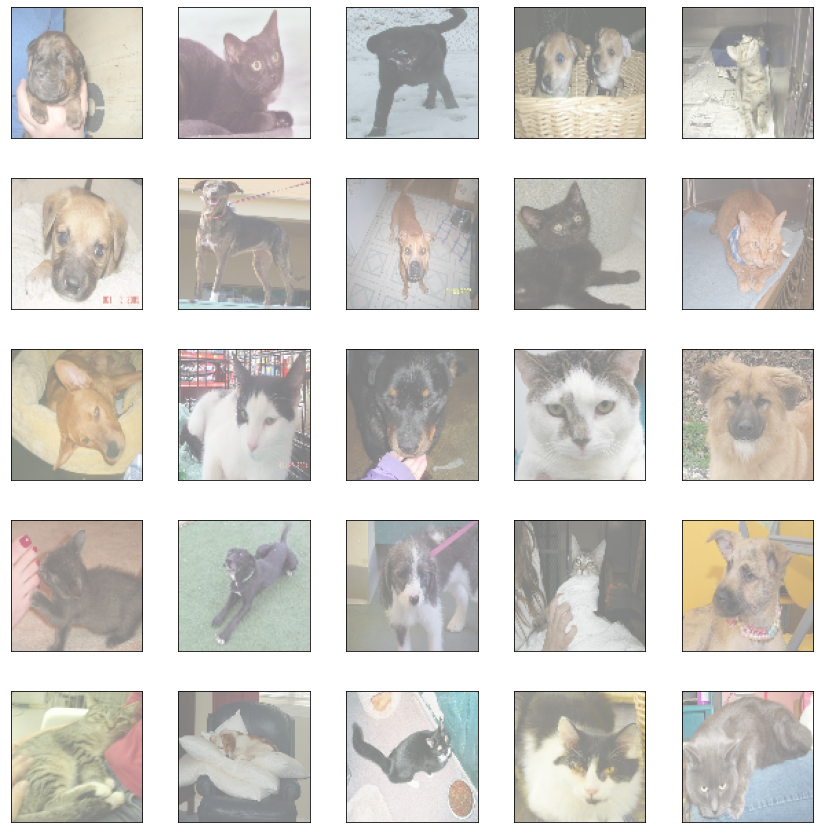

In [14]:
plot_features((train_images * 127.5 + 127.5) / 255.,examples=25)

In [15]:
print("Dog features shape:", train_images.shape)

Dog features shape: (20000, 96, 96, 3)


In [16]:
train_features_tf = tf.cast(train_images, 'float32')

In [17]:
def flip(x: tf.Tensor) -> (tf.Tensor):
    x = tf.image.random_flip_left_right(x)
    return x

In [18]:
sample_size = 12000
batch_size = 128
weight_init_std = 0.02
weight_init_mean = 0.0
leaky_relu_slope = 0.2
downsize_factor = 2
dropout_rate = 0.5
scale_factor = 4 ** downsize_factor
lr_initial_d = tf.Variable(0.0002)
lr_initial_g = tf.Variable(0.0002)
lr_decay_steps = 1000
noise_dim = 128

In [19]:
train_features_data = tf.data.Dataset.from_tensor_slices(train_features_tf).shuffle(sample_size).map(flip).batch(batch_size, drop_remainder=True)

In [20]:
print(train_features_data)

<BatchDataset shapes: (128, 96, 96, 3), types: tf.float32>


In [21]:
weight_initializer = tf.keras.initializers.TruncatedNormal(stddev=weight_init_std, mean=weight_init_mean, seed=256)

In [22]:
def transposed_conv(model, out_channels, ksize, stride_size, ptype='same'):
    model.add(Conv2DTranspose(out_channels, (ksize, ksize),
                              strides=(stride_size, stride_size), padding=ptype, 
                              kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())
    return model

def transposed_convSN(model, out_channels, ksize, stride_size, ptype='same'):
    model.add(ConvSN2DTranspose(out_channels, (ksize, ksize), 
                              strides=(stride_size, stride_size), padding=ptype, 
                              kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())
    return model

def convSN(model, out_channels, ksize, stride_size):
    model.add(ConvSN2D(out_channels, (ksize, ksize), strides=(stride_size, stride_size), padding='same',
                     kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=leaky_relu_slope))
    #model.add(Dropout(dropout_rate))
    return model

def conv(model, out_channels, ksize, stride_size):
    model.add(Conv2D(out_channels, (ksize, ksize), strides=(stride_size, stride_size), padding='same',
                     kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=leaky_relu_slope))
    #model.add(Dropout(dropout_rate))
    return model

In [23]:
def myGenerator():
    model = Sequential()
    model.add(Dense(image_width // scale_factor * image_height // scale_factor * 128,
                    input_shape=(noise_dim,), kernel_initializer=weight_initializer))
    #model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MOMENTUM))
    #model.add(LeakyReLU(alpha=leaky_relu_slope))
    model.add(Reshape((image_height // scale_factor, image_width // scale_factor, 128)))
    
    model = transposed_conv(model, 512, ksize=5, stride_size=1)
    model.add(Dropout(dropout_rate))
    model = transposed_conv(model, 256, ksize=5, stride_size=2)
    model.add(Dropout(dropout_rate))
    model = transposed_conv(model, 128, ksize=5, stride_size=2)
    model = transposed_conv(model, 64, ksize=5, stride_size=2)
    model = transposed_conv(model, 32, ksize=5, stride_size=2)
    
    model.add(Dense(3, activation='tanh', kernel_initializer=weight_initializer))

    return model

In [24]:
my_generator = myGenerator()
print(my_generator.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4608)              594432    
_________________________________________________________________
reshape (Reshape)            (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 6, 6, 512)         1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 6, 512)         2048      
_________________________________________________________________
re_lu (ReLU)                 (None, 6, 6, 512)         0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 12, 12, 256)       3

(1, 96, 96, 3)
(1, 128) -0.096669495 0.8979054


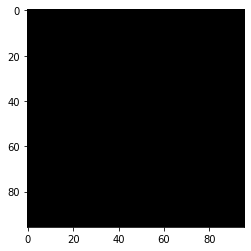

In [25]:
# random noise vector
noise = tf.random.normal([1,noise_dim])
#sample = generate_latent_points(100, 50)
# run the generator model with the noise vector as input
generated_image = my_generator(noise, training=False)
# display output
plt.imshow(generated_image[0, :, :, :])
print(generated_image.shape)
#print(sample.shape, sample.mean(), sample.std())
print(noise.shape, tf.math.reduce_mean(noise).numpy(), tf.math.reduce_std(noise).numpy())

In [26]:
def myDiscriminator(spectral_normalization=False):
    model = Sequential()
    model.add(Conv2D(64, (4, 4), strides=(2,2), padding='same', use_bias=False,
                      input_shape=[image_height, image_width, image_channels], 
                      kernel_initializer=weight_initializer))
    #model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MOMENTUM))
    model.add(LeakyReLU(alpha=leaky_relu_slope))
    #model.add(Dropout(dropout_rate))

    model = conv(model, 64, ksize=4, stride_size=2)
    #model = convSN(model, 128, ksize=3, stride_size=1)
    model = conv(model, 128, ksize=4, stride_size=2)
    #model = convSN(model, 256, ksize=3, stride_size=1)
    model = conv(model, 256, ksize=4, stride_size=2)
    #model = convSN(model, 512, ksize=3, stride_size=1)

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [27]:
my_discriminator = myDiscriminator(spectral_normalization=False)
print(my_discriminator.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        3072      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        65536     
_________________________________________________________________
batch_normalization_5 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       131072    
_________________________________________________________________
batch_normalization_6 (Batch (None, 12, 12, 128)      

In [28]:
decision = my_discriminator(generated_image)
print(decision)

tf.Tensor([[0.5000006]], shape=(1, 1), dtype=float32)


In [29]:
# Label smoothing -- technique from GAN hacks, instead of assigning 1/0 as class labels, we assign a random integer in range [0.7, 1.0] for positive class
# and [0.0, 0.3] for negative class

def smooth_positive_labels(y):
    return y - 0.3 + (np.random.random(y.shape) * 0.5)

def smooth_negative_labels(y):
    return y + np.random.random(y.shape) * 0.3

In [30]:
# randomly flip some labels
def noisy_labels(y, p_flip):
    # determine the number of labels to flip
    n_select = int(p_flip * int(y.shape[0]))
    # choose labels to flip
    flip_ix = np.random.choice([i for i in range(int(y.shape[0]))], size=n_select)
    
    op_list = []
    # invert the labels in place
    #y_np[flip_ix] = 1 - y_np[flip_ix]
    for i in range(int(y.shape[0])):
        if i in flip_ix:
            op_list.append(tf.subtract(1, y[i]))
        else:
            op_list.append(y[i])
    
    outputs = tf.stack(op_list)
    return outputs

In [31]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_initial_g,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_initial_d,beta_1=0.5)
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [32]:
def discriminator_loss(real_output, fake_output, loss_func, apply_label_smoothing=True, label_noise=True):
    if label_noise and apply_label_smoothing:
        real_output_noise = noisy_labels(tf.ones_like(real_output), 0.05)
        fake_output_noise = noisy_labels(tf.zeros_like(fake_output), 0.05)
        real_output_smooth = smooth_positive_labels(real_output_noise)
        fake_output_smooth = smooth_negative_labels(fake_output_noise)
        if loss_func == 'gan': 
            real_loss = cross_entropy(tf.ones_like(real_output_smooth), real_output)
            fake_loss = cross_entropy(tf.zeros_like(fake_output_smooth), fake_output)
        else:
            if loss_func == 'ralsgan':
                return (tf.reduce_mean(tf.square(real_output_smooth - tf.reduce_mean(fake_output_smooth) - tf.ones_like(real_output_smooth)))
        + tf.reduce_mean(tf.square(fake_output_smooth - tf.reduce_mean(real_output_smooth) + tf.ones_like(fake_output_smooth)))) / 2.
            elif loss_func == 'rasgan':
                avg_fake_logit = tf.reduce_mean(fake_output_smooth)
                avg_real_logit = tf.reduce_mean(real_output_smooth)
                D_r_tilde = tf.nn.sigmoid(real_output_smooth - avg_fake_logit)
                D_f_tilde = tf.nn.sigmoid(fake_output_smooth - avg_real_logit)
                total_loss = - tf.reduce_mean(tf.log(
                    D_r_tilde + 1e-14)) - tf.reduce_mean(tf.log(1 - D_f_tilde + 1e-14))
                return total_loss
            elif loss_func == 'rahinge':
                real_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(real_output_smooth) - (real_output_smooth - tf.reduce_mean(fake_output_smooth))))
                fake_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(fake_output_smooth) + (fake_output_smooth - tf.reduce_mean(real_output_smooth))))
        total_loss = real_loss + fake_loss
        return total_loss
    elif label_noise and not apply_label_smoothing:
        real_output_noise = noisy_labels(tf.ones_like(real_output), 0.05)
        fake_output_noise = noisy_labels(tf.zeros_like(fake_output), 0.05)
        if loss_func == 'gan': 
            real_loss = cross_entropy(tf.ones_like(real_output_noise), real_output)
            fake_loss = cross_entropy(tf.zeros_like(fake_output_noise), fake_output)
        else:
            if loss_func == 'ralsgan':
                return (tf.reduce_mean(tf.square(real_output_noise - tf.reduce_mean(fake_output_noise) - tf.ones_like(real_output_noise)))
        + tf.reduce_mean(tf.square(fake_output_noise - tf.reduce_mean(real_output_noise) + tf.ones_like(fake_output_noise)))) / 2.
            elif loss_func == 'rasgan':
                avg_fake_logit = tf.reduce_mean(fake_output_noise)
                avg_real_logit = tf.reduce_mean(real_output_noise)
                D_r_tilde = tf.nn.sigmoid(real_output_noise - avg_fake_logit)
                D_f_tilde = tf.nn.sigmoid(fake_output_noise - avg_real_logit)
                total_loss = - tf.reduce_mean(tf.log(
                    D_r_tilde + 1e-14)) - tf.reduce_mean(tf.log(1 - D_f_tilde + 1e-14))
                return total_loss
            elif loss_func == 'rahinge':
                real_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(real_output_noise) - (real_output_noise - tf.reduce_mean(fake_output_noise))))
                fake_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(fake_output_noise) + (fake_output_noise - tf.reduce_mean(real_output_noise))))
        total_loss = real_loss + fake_loss
        return total_loss
    elif apply_label_smoothing and not label_noise:
        real_output_smooth = smooth_positive_labels(tf.ones_like(real_output))
        fake_output_smooth = smooth_negative_labels(tf.zeros_like(fake_output))
        if loss_func == 'gan': 
            real_loss = cross_entropy(tf.ones_like(real_output_smooth), real_output)
            fake_loss = cross_entropy(tf.zeros_like(fake_output_smooth), fake_output)
        else:
            if loss_func == 'ralsgan':
                return (tf.reduce_mean(tf.square(real_output_smooth - tf.reduce_mean(fake_output_smooth) - tf.ones_like(real_output_smooth)))
        + tf.reduce_mean(tf.square(fake_output_smooth - tf.reduce_mean(real_output_smooth) + tf.ones_like(fake_output_smooth)))) / 2.
            elif loss_func == 'rasgan':
                avg_fake_logit = tf.reduce_mean(fake_output_smooth)
                avg_real_logit = tf.reduce_mean(real_output_smooth)
                D_r_tilde = tf.nn.sigmoid(real_output_smooth - avg_fake_logit)
                D_f_tilde = tf.nn.sigmoid(fake_output_smooth - avg_real_logit)
                total_loss = - tf.reduce_mean(tf.log(
                    D_r_tilde + 1e-14)) - tf.reduce_mean(tf.log(1 - D_f_tilde + 1e-14))
                return total_loss
            elif loss_func == 'rahinge':
                real_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(real_output_smooth) - (real_output_smooth - tf.reduce_mean(fake_output_smooth))))
                fake_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(fake_output_smooth) + (fake_output_smooth - tf.reduce_mean(real_output_smooth))))
        total_loss = real_loss + fake_loss
        return total_loss    
    else:
        if loss_func == 'gan': 
            real_loss = cross_entropy(tf.ones_like(real_output), real_output)
            fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        else:
            if loss_func == 'ralsgan':
                return (tf.reduce_mean(tf.square(real_output - tf.reduce_mean(fake_output) - tf.ones_like(real_output)))
        + tf.reduce_mean(tf.square(fake_output - tf.reduce_mean(real_output) + tf.ones_like(fake_output)))) / 2.
            elif loss_func == 'rasgan':
                avg_fake_logit = tf.reduce_mean(fake_output)
                avg_real_logit = tf.reduce_mean(real_output)
                D_r_tilde = tf.nn.sigmoid(real_output - avg_fake_logit)
                D_f_tilde = tf.nn.sigmoid(fake_output - avg_real_logit)
                total_loss = - tf.reduce_mean(tf.log(
                    D_r_tilde + 1e-14)) - tf.reduce_mean(tf.log(1 - D_f_tilde + 1e-14))
                return total_loss
            elif loss_func == 'rahinge':
                real_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(real_output) - (real_output - tf.reduce_mean(fake_output))))
                fake_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(fake_output) + (fake_output - tf.reduce_mean(real_output))))
        total_loss = real_loss + fake_loss
        return total_loss

In [33]:
def generator_loss(real_output, fake_output, loss_func, apply_label_smoothing=True):
    if apply_label_smoothing:
        fake_output_smooth = smooth_negative_labels(tf.ones_like(fake_output))
        if loss_func == 'gan':
            return cross_entropy(tf.ones_like(fake_output_smooth), fake_output)
        else:
            if loss_func == 'ralsgan':
                return (tf.reduce_mean(tf.square(real_output - tf.reduce_mean(fake_output_smooth) + tf.ones_like(real_output)))
        + tf.reduce_mean(tf.square(fake_output_smooth - tf.reduce_mean(real_output) - tf.ones_like(fake_output_smooth)))) / 2.
            elif loss_func == 'rasgan':
                avg_fake_logit = tf.reduce_mean(fake_output_smooth)
                avg_real_logit = tf.reduce_mean(real_output)
                D_r_tilde = tf.nn.sigmoid(real_output - avg_fake_logit)
                D_f_tilde = tf.nn.sigmoid(fake_output_smooth - avg_real_logit)
                total_loss = - tf.reduce_mean(tf.log(
                    D_f_tilde + 1e-14)) - tf.reduce_mean(tf.log(1 - D_r_tilde + 1e-14))
                return total_loss
            elif loss_func == 'rahinge':
                fake_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(fake_output_smooth) - (fake_output_smooth - tf.reduce_mean(real_output))))
                real_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(real_output) + (real_output - tf.reduce_mean(fake_output_smooth))))
                loss = fake_loss + real_loss
                return loss
    else:           
        if loss_func == 'gan':
            return cross_entropy(tf.ones_like(fake_output), fake_output)
        else:
            if loss_func == 'ralsgan':
                return (tf.reduce_mean(tf.square(real_output - tf.reduce_mean(fake_output) + tf.ones_like(real_output)))
        + tf.reduce_mean(tf.square(fake_output - tf.reduce_mean(real_output) - tf.ones_like(fake_output)))) / 2.
            elif loss_func == 'rasgan':
                avg_fake_logit = tf.reduce_mean(fake_output)
                avg_real_logit = tf.reduce_mean(real_output)
                D_r_tilde = tf.nn.sigmoid(real_output - avg_fake_logit)
                D_f_tilde = tf.nn.sigmoid(fake_output - avg_real_logit)
                total_loss = - tf.reduce_mean(tf.log(
                    D_f_tilde + 1e-14)) - tf.reduce_mean(tf.log(1 - D_r_tilde + 1e-14))
                return total_loss
            elif loss_func == 'rahinge':
                fake_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(fake_output) - (fake_output - tf.reduce_mean(real_output))))
                real_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(real_output) + (real_output - tf.reduce_mean(fake_output))))
                loss = fake_loss + real_loss
                return loss 

In [34]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=my_generator,
                                 discriminator=my_discriminator)

In [35]:
EPOCHS = 1000
num_examples_to_generate = 50
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [36]:
def train_step(images, loss_type='gan'):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = my_generator(noise, training=True)
        
        real_output = my_discriminator(images, training=True)
        fake_output = my_discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(real_output, fake_output, loss_type, apply_label_smoothing=True)
        disc_loss = discriminator_loss(real_output, fake_output, loss_type, 
                                       apply_label_smoothing=True, label_noise=True)
 
    gradients_of_generator = gen_tape.gradient(gen_loss, my_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, my_discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, my_generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, my_discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [37]:
def plot_losses(G_losses, D_losses, all_gl, all_dl, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH {}".format(epoch))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    ymax = plt.ylim()[1]
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(len(all_gl)),all_gl,label='G')
    plt.plot(np.arange(len(all_dl)),all_dl,label='D')
    plt.legend()
    #plt.ylim((0,np.min([1.1*np.max(all_gl),2*ymax])))
    plt.title('All Time Loss')
    plt.show()

In [38]:
def generate_and_save_images(model, epoch, test_input, rows, cols):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(14,14))
    for i in range(predictions.shape[0]):
        plt.subplot(rows, cols, i+1)
        plt.imshow((predictions[i, :, :, :] * 127.5 + 127.5) / 255.)
        plt.axis('off') 
        
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [39]:
def generate_test_image(model, noise_dim=noise_dim):
    test_input = tf.random.normal([1, noise_dim])
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(5,5))
    plt.imshow((predictions[0, :, :, :] * 127.5 + 127.5) / 255.)
    plt.axis('off') 
    plt.show()

In [40]:
def zip_images(filename='images.zip'):
    # SAVE TO ZIP FILE NAMED IMAGES.ZIP
    z = zipfile.PyZipFile(filename, mode='w')
    for k in range(image_sample_size):
        generated_image = my_generator(tf.random.normal([1, noise_dim]), training=False)
        f = str(k)+'.png'
        img = np.array(generated_image)
        img = (img[0, :, :, :] + 1.) / 2.
        img = Image.fromarray((255*img).astype('uint8').reshape((image_height,image_width,image_channels)))
        img.save(f,'PNG')
        z.write(f)
        os.remove(f)
        #if k % 1000==0: print(k)
    z.close()
    print('Saved final images for submission.')
    
def save_images(directory=OUT_DIR):
    for k in range(image_sample_size):
        generated_image = my_generator(tf.random.normal([1, noise_dim]), training=False)
        f = str(k)+'.png'
        f = os.path.join(directory, f)
        img = np.array(generated_image)
        img = (img[0, :, :, :] + 1.) / 2.
        img = Image.fromarray((255*img).astype('uint8').reshape((image_height,image_width,image_channels)))
        img.save(f,'PNG')
        #if k % 1000==0: print(k)
    print('Saved temporary images for evaluation.')

In [41]:
display_results = 20
calculate_mifid = 100
replay_step = 25
decay_step = 25

def save_model_func():
  
  my_discriminator.save('/content/drive/My Drive/HW7/save_model/cat_dog_discriminator.h5')
  my_generator.save('/content/drive/My Drive/HW7/save_model/cat_dog_generator.h5')

def train(dataset, epochs):
    all_gl = np.array([]); all_dl = np.array([])
    
    exp_replay = []
    for epoch in tqdm(range(epochs)):
        
        G_loss = []; D_loss = []
        
        start = time.time()
        new_lr_d = lr_initial_d
        new_lr_g = lr_initial_g
        global_step = 0
        
        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
            global_step = global_step + 1
            G_loss.append(g_loss); D_loss.append(d_loss)
            all_gl = np.append(all_gl,np.array([G_loss]))
            all_dl = np.append(all_dl,np.array([D_loss]))
        
         
        #display.clear_output(wait=True)
        if (epoch + 1) % display_results == 0 or epoch == 0:
            plot_losses(G_loss, D_loss, all_gl, all_dl, epoch + 1)
            generate_and_save_images(my_generator, epoch + 1, seed, rows=10, cols=10)
        
        if (epoch + 1) % calculate_mifid == 0:            
            OUT_DIR.mkdir(exist_ok=True)
            save_images(OUT_DIR)

        
        # Cosine learning rate decay
        if (epoch + 1) % decay_step == 0:
            new_lr_d = tf.keras.experimental.CosineDecay(new_lr_d, min(global_step, lr_decay_steps), lr_decay_steps)
            new_lr_g = tf.keras.experimental.CosineDecay(new_lr_g, min(global_step, lr_decay_steps), lr_decay_steps)
            generator_optimizer = tf.keras.optimizers.Adam(learning_rate=new_lr_d,beta_1=0.5)
            discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=new_lr_g,beta_1=0.5)          

        print('Epoch: {} computed for {} sec'.format(epoch + 1, time.time() - start))
        print('Generator mean_loss : ', np.mean(G_loss),' std: ', np.std(G_loss))
        print('Discriminator mean_loss : ', np.mean(D_loss),' std: ', np.std(D_loss))

        if(epoch%50==0):
            # Generate after every 50th epoch
            # display.clear_output(wait=True)
            # final_seed = tf.random.normal([64, noise_dim])
            
            checkpoint.save(file_prefix = checkpoint_prefix)
            save_model_func()
    
    generate_and_save_images(my_generator, epochs, seed, rows=10, cols=10)
    checkpoint.save(file_prefix = checkpoint_prefix)
    save_model_func()
    
    OUT_DIR.mkdir(exist_ok=True)
    save_images(OUT_DIR)
    shutil.rmtree(OUT_DIR)
    print('Removed temporary image directory.')
    
    
    print('Final epoch.')

  0%|          | 0/1000 [00:00<?, ?it/s]

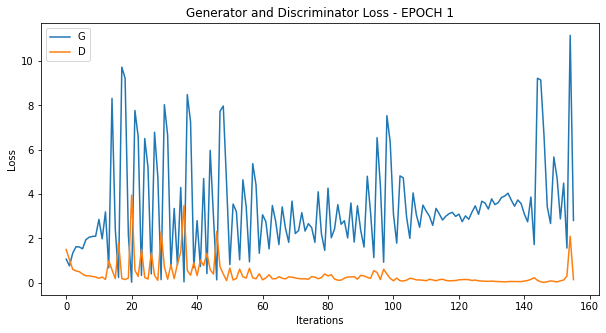

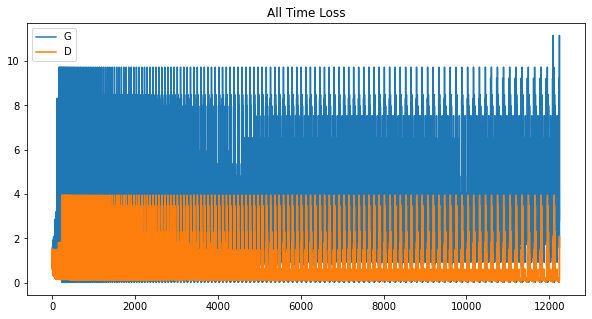

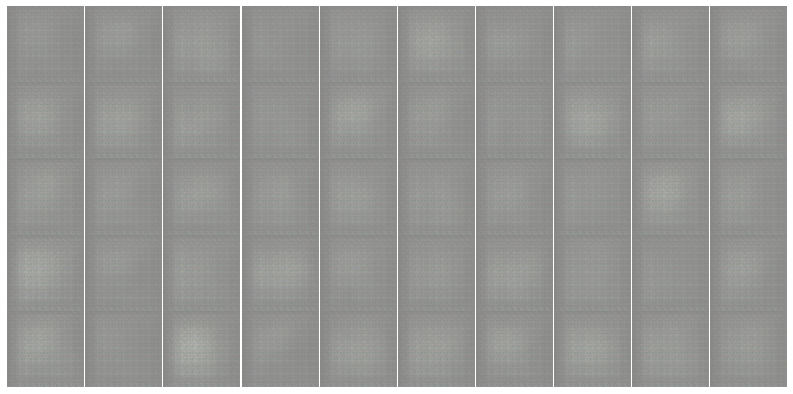

Epoch: 1 computed for 71.82615828514099 sec
Generator mean_loss :  3.3954346  std:  2.1454659
Discriminator mean_loss :  0.38541403  std:  0.5618217


  0%|          | 2/1000 [02:22<20:02:09, 72.27s/it]

Epoch: 2 computed for 69.27271866798401 sec
Generator mean_loss :  2.973402  std:  1.7295147
Discriminator mean_loss :  0.5265011  std:  0.8233364


  0%|          | 3/1000 [03:33<19:50:50, 71.67s/it]

Epoch: 3 computed for 70.23910665512085 sec
Generator mean_loss :  1.8497577  std:  1.1723397
Discriminator mean_loss :  0.8433388  std:  0.54760313


  0%|          | 4/1000 [04:43<19:44:49, 71.38s/it]

Epoch: 4 computed for 70.69128584861755 sec
Generator mean_loss :  2.0126941  std:  0.9762652
Discriminator mean_loss :  0.67530555  std:  0.36742458


  0%|          | 5/1000 [05:54<19:41:53, 71.27s/it]

Epoch: 5 computed for 71.01749062538147 sec
Generator mean_loss :  1.8624722  std:  0.9524579
Discriminator mean_loss :  0.82840466  std:  0.44724482


  1%|          | 6/1000 [07:05<19:40:14, 71.24s/it]

Epoch: 6 computed for 71.17174410820007 sec
Generator mean_loss :  1.6316608  std:  0.59761524
Discriminator mean_loss :  0.83197314  std:  0.23170088


  1%|          | 7/1000 [08:17<19:39:33, 71.27s/it]

Epoch: 7 computed for 71.33700203895569 sec
Generator mean_loss :  1.5331762  std:  0.57587564
Discriminator mean_loss :  0.8984235  std:  0.3233913


  1%|          | 8/1000 [09:28<19:39:12, 71.32s/it]

Epoch: 8 computed for 71.43777561187744 sec
Generator mean_loss :  1.7462298  std:  0.8099109
Discriminator mean_loss :  0.80006874  std:  0.2738883


  1%|          | 9/1000 [10:40<19:38:06, 71.33s/it]

Epoch: 9 computed for 71.33563017845154 sec
Generator mean_loss :  1.8743625  std:  0.86770946
Discriminator mean_loss :  0.77785265  std:  0.3711627


  1%|          | 10/1000 [11:51<19:37:38, 71.37s/it]

Epoch: 10 computed for 71.46722841262817 sec
Generator mean_loss :  1.4382693  std:  0.58918244
Discriminator mean_loss :  1.0124259  std:  0.29384458


In [ ]:
train(train_features_data, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
my_generator.compile(optimizer="adam",loss="mse")

In [ ]:
generate_test_image(my_generator)
my_generator = tf.keras.models.load_model("/content/drive/My Drive/HW7/save_model/cat_dog_generator.h5")

In [ ]:
generate_test_image(my_generator)

In [ ]:
# Display a single image using the epoch number

def display_image(epoch_no):
    return Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 1*(i**2)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    IPython.display.Image(filename=anim_file)